# Upscaling using Renormalization

This notebook presents how to use renromalization to upscale a 3D field of hydraulic conductivity
Three methods are used:
- Simplified renormalization
- Standard renormalization
- Tensorial renormalization

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
from numba import jit

## Simplified renormalization

In [2]:
@jit()
def hmean(v1, v2, w1=1, w2=1):
    return (w1 + w2) / (w1 / v1 + w2 / v2)

@jit()
def mean(v1, v2, w1=1, w2=1):
    return (v1 * w1 + v2 * w2) / (w1 + w2)

In [3]:
# create functions to compute the equivalent permeability of a 2D field
# This is done by computing the arithmetic mean / or the harmonic mean in the x and y directions sequentially until the final value is obtained

def f_3D(a, dx=None, dy=None, dz=None, direction="x", typ="x"):

    """
    Function to operate a mean between two 2D fields from a 3D field

    Parameters
    ----------
    a : 3D numpy array
        The 3D field
    direction : str
        The direction of the mean to compute. Can be "x", "y" or "z"
    type : str
        The direction where fields are selected. Can be "x", "y" or "z"
    """

    # initialize weights
    w1 = 1
    w2 = 1
    new_dx = None
    new_dy = None
    new_dz = None

    if typ == "y":

        v1 = a[:, ::2, :]
        v2 = a[:, 1::2, :]
        if dy is not None:
            w1 = dy[:, ::2, :]
            w2 = dy[:, 1::2, :]
            new_dy = w1 + w2
            new_dx = dx[:, ::2, :]
            new_dz = dz[:, ::2, :]

    elif typ == "x":

        v1 = a[:, :, ::2]
        v2 = a[:, :, 1::2]
        if dx is not None:
            w1 = dx[:, :, ::2]
            w2 = dx[:, :, 1::2]
            new_dx = w1 + w2
            new_dy = dy[:, :, ::2]
            new_dz = dz[:, :, ::2]

    elif typ == "z":
            
        v1 = a[::2, :, :]
        v2 = a[1::2, :, :]
        if dz is not None:
            w1 = dz[::2, :, :]
            w2 = dz[1::2, :, :]
            new_dz = w1 + w2
            new_dx = dx[::2, :, :]
            new_dy = dy[::2, :, :]


    if typ == direction:  # series
        res = hmean(v1, v2, w1=w1, w2=w2)
    else:
        res = mean(v1, v2, w1=w1, w2=w2)
    
    return res, new_dx, new_dy, new_dz

def test_f():

    """
    Test the function f
    """
    a = np.array([[[0.51394334, 0.77316505],
                   [0.87042769, 0.00804695]],
                  [[0.30973593, 0.95760374],
                   [0.51311671, 0.31828442]]])

    a1 = f_3D(a, direction="x", typ="x")[0]
    a2 = f_3D(a1, direction="x", typ="z")[0]
    a3 = f_3D(a2, direction="x", typ="y")[0]
    res = a3[0, 0, 0]
    assert np.allclose(res, 0.3735857397539791)
    
    a1 = f_3D(a, direction="x", typ="y")[0]
    a2 = f_3D(a1, direction="x", typ="z")[0]
    a3 = f_3D(a2, direction="x", typ="x")[0]
    res = a3[0, 0, 0]
    assert np.allclose(res, 0.5323798506575812)

    print("Test passed")


# from numba import jit
# @jit(nopython=True)
def merge(v1, v2, w1, w2, normalize=True):
    
    """
    Function to merge two vectors v1 and v2 with weights w1 and w2
    Is used here to merge two columns of different sizes
    """

    if normalize:
        sum_w = w1 + w2
        w1 = w1 / sum_w
        w2 = w2 / sum_w

    return w1*v1 + w2*v2 - (w1*w2*(v1 - v2)**2)/(w1*v2 + w2*v1)

In [4]:
np.random.seed(14)
a = np.random.rand(2, 2, 2)

dx = np.ones((2, 2, 2)) 
dx[:, :, -1] = 2
a1, ndx, ndy, ndz = f_3D(a, direction="x", typ="x", dx=dx, dy=np.ones((2, 2, 2)), dz=np.ones((2, 2, 2)))
a1

array([[[0.66188498],
        [0.01201489]],

       [[0.56421699],
        [0.3644066 ]]])

In [5]:
np.random.seed(14)

a = np.random.rand(2, 2, 2)

a1 = f_3D(a, direction="x", typ="x")
a2 = f_3D(a1[0], direction="x", typ="z")
a3 = f_3D(a2[0], direction="x", typ="y")
print(a3[0][0, 0, 0])

a1 = f_3D(a, direction="x", typ="y")
a2 = f_3D(a1[0], direction="x", typ="z")
a3 = f_3D(a2[0], direction="x", typ="x")
print(a3[0][0, 0, 0])

0.3735857397539791
0.5323798506575812


In [6]:
test_f()

Test passed


In [7]:
def find_c_3D(k_field, direction="x", typ="min", dx=None, dy=None, dz=None):
    
    if typ == "min":
        if direction == "x":
            l_typ = ["x", "y", "z"]
        elif direction == "y":
            l_typ = ["y", "x", "z"]
        elif direction == "z":
            l_typ = ["z", "x", "y"]
    elif typ == "max":
        if direction == "x":
            l_typ = ["y", "z", "x"]
        elif direction == "y":
            l_typ = ["x", "z", "y"]
        elif direction == "z":
            l_typ = ["x", "y", "z"]

    # if dx, dy and dz are None, set them to 1
    if dx is None:
        dx = 1
    if dy is None:
        dy = 1
    if dz is None:
        dz = 1

    # if dx and dy are provided as a scalar, set them to an array of the same shape as k_field
    if isinstance(dx, (int, float)):
        dx = np.ones(k_field.shape) * dx
    if isinstance(dy, (int, float)):
        dy = np.ones(k_field.shape) * dy
    if isinstance(dz, (int, float)):
        dz = np.ones(k_field.shape) * dz

    a = np.copy(k_field)
    o = 0
    while a.flatten().shape[0] > 1:
        # print("dx:", dx)
        # print("dy:", dy)
        # print("dz:", dz)
        # print("asdf", a)
        # check if the number of elements is odd
        rm_col = False
        rm_row = False
        rm_lay = False
        rm_dx = None
        rm_dy = None
        rm_dz = None
        sim = True
        if l_typ[o] == "x":
            if a.shape[2] > 1:
                if a.shape[2] % 2 == 1:
                    # remove the last column
                    rm_col = a[:, :, -1]
                    a = a[:, :, :-1]
                    rm_dx = dx[:, :, -1]
                    dx = dx[:, :, :-1]
                    rm_dy = dy[:, :, -1]
                    dy = dy[:, :, :-1]
                    rm_dz = dz[:, :, -1]
                    dz = dz[:, :, :-1]
            else:
                sim = False

        elif l_typ[o] == "y":
            if a.shape[1] > 1:
                if a.shape[1] % 2 == 1:
                    # remove the last row
                    rm_row = a[:, -1, :]
                    a = a[:, :-1, :]
                    rm_dx = dx[:, -1, :]
                    dx = dx[:, :-1, :]
                    rm_dy = dy[:, -1, :]
                    dy = dy[:, :-1, :]
                    rm_dz = dz[:, -1, :]
                    dz = dz[:, :-1, :]
            else:
                sim = False

        elif l_typ[o] == "z":
            if a.shape[0] > 1:
                if a.shape[0] % 2 == 1:
                    # remove the last layer
                    rm_lay = a[-1, :, :]
                    a = a[:-1, :, :]
                    rm_dx = dx[-1, :, :]
                    dx = dx[:-1, :, :]
                    rm_dy = dy[-1, :, :]
                    dy = dy[:-1, :, :]
                    rm_dz = dz[-1, :, :]
                    dz = dz[:-1, :, :]
            else:
                sim = False
        if sim:
            a, dx, dy, dz = f_3D(a, direction=direction, typ=l_typ[o], dx=dx, dy=dy, dz=dz)

        # merge the removed column, row or layer
        if rm_col is not False:
            # new_col = merge(rm_col, a[:, :, -1], 1, 2)
            a = np.dstack((a, rm_col.reshape(a.shape[0], a.shape[1], 1)))
            dx = np.dstack((dx, rm_dx.reshape(dx.shape[0], dx.shape[1], 1)))
            dy = np.dstack((dy, rm_dy.reshape(dy.shape[0], dy.shape[1], 1)))
            dz = np.dstack((dz, rm_dz.reshape(dz.shape[0], dz.shape[1], 1)))
        elif rm_row is not False:
            # new_row = merge(rm_row, a[:, -1, :], 1, 2)
            a = np.hstack((a, rm_row.reshape(a.shape[0], 1, a.shape[2])))
            dx = np.hstack((dx, rm_dx.reshape(dx.shape[0], 1, dx.shape[2])))
            dy = np.hstack((dy, rm_dy.reshape(dy.shape[0], 1, dy.shape[2])))
            dz = np.hstack((dz, rm_dz.reshape(dz.shape[0], 1, dz.shape[2])))
        elif rm_lay is not False:
            # new_lay = merge(rm_lay, a[-1, :, :], 1, 2)
            a = np.vstack((a, rm_lay.reshape(1, a.shape[1], a.shape[2])))
            dx = np.vstack((dx, rm_dx.reshape(1, dx.shape[1], dx.shape[2])))
            dy = np.vstack((dy, rm_dy.reshape(1, dy.shape[1], dy.shape[2])))
            dz = np.vstack((dz, rm_dz.reshape(1, dz.shape[1], dz.shape[2])))

        o += 1
        if o == 3:
            o = 0

    return a[0, 0, 0]

In [85]:
def plot_field(field, cmap="viridis"):

    # set pyvista backend local
    pv.set_jupyter_backend('client')

    # plot 3D plot of the field
    grid = pv.ImageData()

    grid.dimensions = np.array(field.shape) + 1
    grid.spacing = np.array([1, 1, 1])
    grid.origin = (0, 0, 0)

    grid.cell_data["Permeability"] = field.flatten(order="F")

    grid.plot(show_scalar_bar=True, show_edges=True, cmap=cmap)

In [ ]:

dx = np.ones((2, 2, 2)) 
dx[:, :, -1] = 2
find_c_3D(a, direction="x", typ="min", dx=dx, dy=1, dz=1)

0.40063086286875327

In [9]:
a[:, :, 0]

array([[0.51394334, 0.87042769],
       [0.30973593, 0.51311671]])

In [10]:
a

array([[[0.51394334, 0.77316505],
        [0.87042769, 0.00804695]],

       [[0.30973593, 0.95760374],
        [0.51311671, 0.31828442]]])

In [11]:
def test_find_c():

    b = np.array([[[0.51394334, 0.77316505, 0.87042769],
        [0.00804695, 0.30973593, 0.95760374],
        [0.51311671, 0.31828442, 0.53919994]],

       [[0.22125494, 0.80648136, 0.34225463],
        [0.53888885, 0.00587379, 0.67315248],
        [0.21002426, 0.93255759, 0.37424475]],

       [[0.75241892, 0.763139  , 0.87049946],
        [0.11011118, 0.30009198, 0.47490577],
        [0.67293672, 0.25759243, 0.70115132]]])

    cmin = find_c_3D(b, direction="x", typ="min", dx=1, dy=1, dz=1)
    cmax = find_c_3D(b, direction="x", typ="max", dx=1, dy=1, dz=1)
    assert np.allclose(cmin, 0.3914114)
    assert np.allclose(cmax, 0.47437664)

    print("Test passed")

In [12]:
test_find_c()

Test passed


In [13]:
np.random.seed(15)
b = np.random.rand(3, 3, 3)
find_c_3D(b, direction="x", typ="min")

0.3320330491045114

In [14]:
find_c_3D(b, direction="x", typ="max")

0.41554160805609713

In [15]:
np.random.seed(1312)

# create a 2D field
nx, ny, nz = 4, 4, 4
dx, dy, dz = 1, 1, 1

l_c = []
l_c2 = []
for i in range(4000):
    field = 10**(np.random.rand(nx, ny, nz)*-2 + -3)
    c_x_min = find_c_3D(field, direction="x", typ="min")
    c_x_max = find_c_3D(field, direction="x", typ="max")
    l_c.append((c_x_min, c_x_max))
    am = np.mean(field)
    hm = 1/ np.mean(1/field)
    l_c2.append((am, hm))

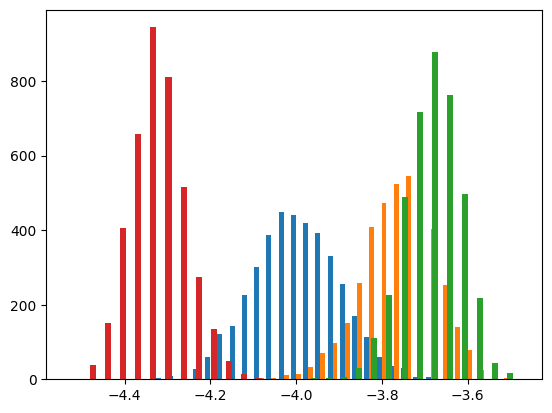

In [16]:
plt.hist(np.log10(np.array(l_c)), bins=30)
plt.hist(np.log10(np.array(l_c2)), bins=30)
plt.show()

In [17]:
# now keq is a function of cmin and cmax according to keq = cmax**alpha*(cmin)**(1-alpha)
def get_alpha(dx, dy, dz=None, direction="x"):
    
    def f_u(t):
        return np.arctan(np.sqrt(t)) / (np.pi/2)

    if dz is None:
        if direction == "x":
            a = dx/dy
        elif direction == "y":
            a = dy/dx
        
        u = f_u(a)
        return u

    if direction == "x":
        a_1 = dx/dy
        a_2 = dx/dz
    elif direction == "y":
        a_1 = dy/dx
        a_2 = dy/dz
    elif direction == "z":
        a_1 = dz/dx
        a_2 = dz/dy
        
    u_1 = f_u(a_1)
    u_2 = f_u(a_2)

    return ((u_1 + u_2) - 2*u_1*u_2) / (1 - u_1*u_2)
    
def keq(cmin, cmax, alpha):
    return cmax**alpha*(cmin)**(1-alpha)

In [18]:
def simplified_renormalization(field, dx, dy, dz, direction="x"):

    cx_min, cx_max = find_c_3D(field, direction=direction, typ="min", dx=dx, dy=dy, dz=dz), find_c_3D(field, direction=direction, typ="max", dx=dx, dy=dy, dz=dz)
    return keq(cx_min, cx_max, get_alpha(dx, dy, dz, direction=direction)) 

In [19]:
np.random.seed(15)
# create a 2D field
nx, ny, nz = 4, 4, 4
dx, dy, dz = 1, 1, 1

Lx = nx * dx
Ly = ny * dy
Lz = nz * dz
field = 10**(np.random.rand(nx, ny, nz)*-4 + -4)


In [20]:

Kxx = simplified_renormalization(field, dx, dy, dz, direction="x")
Kyy = simplified_renormalization(field, dx, dy, dz, direction="y")
Kzz = simplified_renormalization(field, dx, dy, dz, direction="z")
print("Kxx = {:.2E} m/s".format(Kxx))
print("Kyy = {:.2E} m/s".format(Kyy))
print("Kzz = {:.2E} m/s".format(Kzz))
print("Arithmetic mean = {:.2E} m/s".format(np.mean(field)))
print("Harmonic mean = {:.2E} m/s".format(1/np.mean(1/field)))
print("Geometric mean = {:.2E} m/s".format(np.exp(np.mean(np.log(field)))))

Kxx = 9.81E-06 m/s
Kyy = 4.41E-06 m/s
Kzz = 6.45E-06 m/s
Arithmetic mean = 1.47E-05 m/s
Harmonic mean = 1.42E-07 m/s
Geometric mean = 2.14E-06 m/s


## Standard renormalization

In [115]:
a[0]

array([[1, 2],
       [3, 4]])

In [ ]:
# a_yy = np.rot90(a, k=-1)
# a_zz = np.rot90(a, k=-1, axes=(0, 2))

def get_idx (i):
    
    if i == 1:
        idx = (0, 0, 0)
    elif i == 2:
        idx = (0, 0, 1)
    elif i == 3:
        idx = (0, 1, 0)
    elif i == 4:
        idx = (0, 1, 1)
    elif i == 5:
        idx = (1, 0, 0)
    elif i == 6:
        idx = (1, 0, 1)
    elif i == 7:
        idx = (1, 1, 0)
    elif i == 8:
        idx = (1, 1, 1)
    
    return idx

def f_sr(kxx, kyy, kzz, dx, dy, dz, direction="x"):

    def b1(i, u):

        idx = get_idx(i)

        if u == "x":
            du = dx
            ku = kxx[idx]
        elif u == "y":
            du = dy
            ku = kyy[idx]
        elif u == "z":
            du = dz
            ku = kzz[idx]

        return 2 * ku * (dx*dy*dz) / du**2

    def b2(i, j, u):
            
        idx = get_idx(i)
    
        idx2 = get_idx(j)
    
        if u == "x":
            du = dx
            ku = kxx[idx]
            ku2 = kxx[idx2]
        elif u == "y":
            du = dy
            ku = kyy[idx]
            ku2 = kyy[idx2]
        elif u == "z":
            du = dz
            ku = kzz[idx]
            ku2 = kzz[idx2]
    
            return (2 * ku * ku2) /(ku + ku2) * ((dx*dy*dz) / du**2)

    def d(i, j, k, l):

        return b1(i, "x") + b2(i, j, "x") + b2(i, k, "y") + b2(i, l, "z")



In [21]:
import pyvista as pv

# set pyvista backend local
pv.set_jupyter_backend('client')

# plot 3D plot of the field
grid = pv.ImageData()

grid.dimensions = np.array(field.shape) + 1
grid.spacing = np.array([dx, dy, dz])
grid.origin = (0, 0, 0)

grid.cell_data["Permeability"] = field.flatten(order="F")

grid.plot(show_scalar_bar=True, show_edges=True)


Widget(value='<iframe src="http://localhost:50954/index.html?ui=P_0x27bda0cb1d0_0&reconnect=auto" class="pyvis…

In [23]:
import pyvista as pv

# set pyvista backend local
pv.set_jupyter_backend('client')

# plot 3D plot of the field
grid = pv.ImageData()

grid.dimensions = np.array((1, 1, 1)) + 1
grid.spacing = np.array([Lx, Ly, Lz])
grid.origin = (0, 0, 0)

grid.cell_data["Permeability"] = Kxx

p = pv.Plotter()
p.add_mesh(grid, scalars="Permeability", clim=[field.min(), field.max()], cmap="viridis", show_edges=True)
p.show()


Widget(value='<iframe src="http://localhost:50954/index.html?ui=P_0x27bde6e5c50_2&reconnect=auto" class="pyvis…

In [108]:
# some investigations to see how to rotate a 2x2x2 field
a = np.arange(1, 9).reshape(2, 2, 2)
plot_field(a, cmap="jet")
plot_field(np.rot90(a, k=-1), cmap="jet")
plot_field(np.rot90(a, k=-1, axes=(0, 2)), cmap="jet")

Widget(value='<iframe src="http://localhost:50954/index.html?ui=P_0x27be2cab990_30&reconnect=auto" class="pyvi…

Widget(value='<iframe src="http://localhost:50954/index.html?ui=P_0x27be2dac950_31&reconnect=auto" class="pyvi…

Widget(value='<iframe src="http://localhost:50954/index.html?ui=P_0x27be3e0cad0_32&reconnect=auto" class="pyvi…